In [1]:
import pandas as pd
import numpy as np
import pickle
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

### Régression Linéaire

Import

In [2]:
df = pd.read_csv('data/cars_cleaned.csv')

Répartition

In [3]:
y = df['prix']
X = df[['type_carburant', 'aspiration', 'nombre_portes', 'type_carrosserie',
       'roues_motrices', 'emplacement_moteur', 'empattement',
       'longueur_voiture', 'largeur_voiture', 'hauteur_voiture', 'poids_vide',
       'type_moteur', 'nombre_cylindres', 'taille_moteur', 'systeme_carburant',
       'alesage', 'course', 'taux_compression', 'puissance', 'trmin_max',
       'consommation_ville', 'consommation_autoroute', 'marque',
       'modele']]


Preparation du pipeline

In [4]:
# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

In [5]:
numeric_features = [
    'longueur_voiture', 'hauteur_voiture', 'largeur_voiture', 'empattement', 'taille_moteur',
    'poids_vide', 'consommation_ville', 'consommation_autoroute', 'puissance', 'trmin_max',
    'nombre_cylindres', 'alesage', 'course', 'taux_compression'
]

categorial_features = [
    'marque', 'modele', 'type_carrosserie', 'nombre_portes', 'type_carburant', 'emplacement_moteur',
    'systeme_carburant', 'aspiration', 'roues_motrices', 'type_moteur'
]

In [6]:
numeric_transformer_minmax = Pipeline([('minmax', MinMaxScaler())])
numeric_transformer_std = Pipeline([('standard', StandardScaler())])
numeric_transformer_rbst = Pipeline([('standard', RobustScaler())])

In [7]:
categorial_transformer = OneHotEncoder(sparse_output=True, handle_unknown='ignore')

In [8]:
# Add feature selection
numeric_transformer_rbst = Pipeline([
    ('standard', RobustScaler()),
    ('selection', SelectKBest(score_func=f_regression, k=10))  # choose 10 best features
])

In [9]:
# Update preprocessor with feature selection
preprocessor_rbst = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer_rbst, numeric_features),
        ('cat', categorial_transformer, categorial_features)
    ],
    remainder='passthrough'
)

In [10]:
# Create pipeline with RandomForestRegressor
rf = RandomForestRegressor(random_state=42)
pipe_rf = Pipeline([
    ('prep', preprocessor_rbst),
    ('rf', rf)
])

In [11]:
# Search for optimal hyperparameters using GridSearchCV
param_grid = {
    'rf__n_estimators': [100, 200, 500],
    'rf__max_depth': [None, 10, 20, 30],
    'rf__min_samples_split': [2, 5, 10],
    'rf__min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(pipe_rf, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('prep',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num',
                                                                         Pipeline(steps=[('standard',
                                                                                          RobustScaler()),
                                                                                         ('selection',
                                                                                          SelectKBest(score_func=<function f_regression at 0x12afcba60>))]),
                                                                         ['longueur_voiture',
                                                                          'hauteur_voiture',
                                                                          'largeur_voiture',
                                                                          'empattement',
                                                                          'taille_moteur',
                                                                          'poids_vide',
                                                                          'consommation_vi...
                                                                          'type_carburant',
                                                                          'emplacement_moteur',
                                                                          'systeme_carburant',
                                                                          'aspiration',
                                                                          'roues_motrices',
                                                                          'type_moteur'])])),
                                       ('rf',
                                        RandomForestRegressor(random_state=42))]),
             n_jobs=-1,
             param_grid={'rf__max_depth': [None, 10, 20, 30],
                         'rf__min_samples_leaf': [1, 2, 4],
                         'rf__min_samples_split': [2, 5, 10],
                         'rf__n_estimators': [100, 200, 500]},
             scoring='neg_mean_squared_error', verbose=1)

In [12]:
# Get the best parameters
best_params = grid_search.best_params_
print("Meilleurs paramètres trouvés :")
print(best_params)

Meilleurs paramètres trouvés :
{'rf__max_depth': 10, 'rf__min_samples_leaf': 2, 'rf__min_samples_split': 5, 'rf__n_estimators': 500}


In [13]:
# Evaluate the model with the best parameters on the test set
best_model = grid_search.best_estimator_
predictions = best_model.predict(X_test)
score = best_model.score(X_test, y_test)
print("Score R2 avec RandomForestRegressor :")
print(score)

Score R2 avec RandomForestRegressor :
0.9491748696219666


In [14]:
# Save the trained model
pickle.dump(best_model, open('data/best_model.pkl', 'wb'))

### <p style="color:grey">🗒 Learning curve </p>

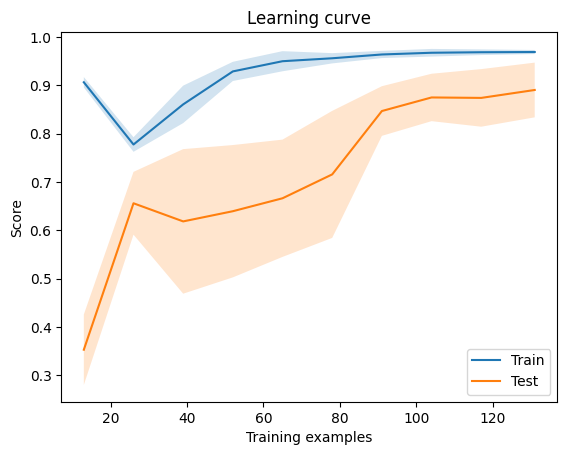

In [16]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    estimator=best_model, X=X_train, y=y_train, cv=5, n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10), scoring="r2")

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean, label="Train")
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2)
plt.plot(train_sizes, test_mean, label="Test")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.2)
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.title("Learning curve")
plt.legend(loc="best")
plt.show()

In [18]:
plt.savefig('Learning_Curve.png')

<Figure size 640x480 with 0 Axes>